In [6]:
import numpy as np
import pandas as pd
from scipy.signal import correlate
import plotly.graph_objects as go

In [7]:
merged1 = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/data/external/aisp_local_nivel_merged.csv', index_col=0, parse_dates=True)
merged2 = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/data/external/snd_local_nivel_merged.csv', index_col=0, parse_dates=True)
merged3 = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/data/external/sil_nivel_merged.csv', index_col=0, parse_dates=True)

In [8]:
merged1_copy = merged1.copy()
merged1_copy['aisp_std'] = (merged1_copy['aisp'] - merged1_copy['aisp'].mean()) / merged1['aisp'].std()
merged1_copy['nivel_std'] = (merged1_copy['nivel'] - merged1_copy['nivel'].mean()) / merged1['nivel'].std()
merged1_real=merged1_copy[['aisp', 'nivel']]
merged1_std=merged1_copy[['aisp_std', 'nivel_std']]

merged2_copy = merged2.copy()
merged2_copy['snd_std'] = (merged2_copy['snd'] - merged2_copy['snd'].mean()) / merged2['snd'].std()
merged2_copy['nivel_std'] = (merged2_copy['nivel'] - merged2_copy['nivel'].mean()) / merged2['nivel'].std()
merged2_real=merged2_copy[['snd', 'nivel']]
merged2_std=merged2_copy[['snd_std', 'nivel_std']]

merged3_copy = merged3.copy()
merged3_copy['sil_std'] = (merged3_copy['sil'] - merged3_copy['sil'].mean()) / merged3['sil'].std()
merged3_copy['nivel_std'] = (merged3_copy['nivel'] - merged3_copy['nivel'].mean()) / merged3['nivel'].std()
merged3_real=merged3_copy[['sil', 'nivel']]
merged3_std=merged3_copy[['sil_std', 'nivel_std']]

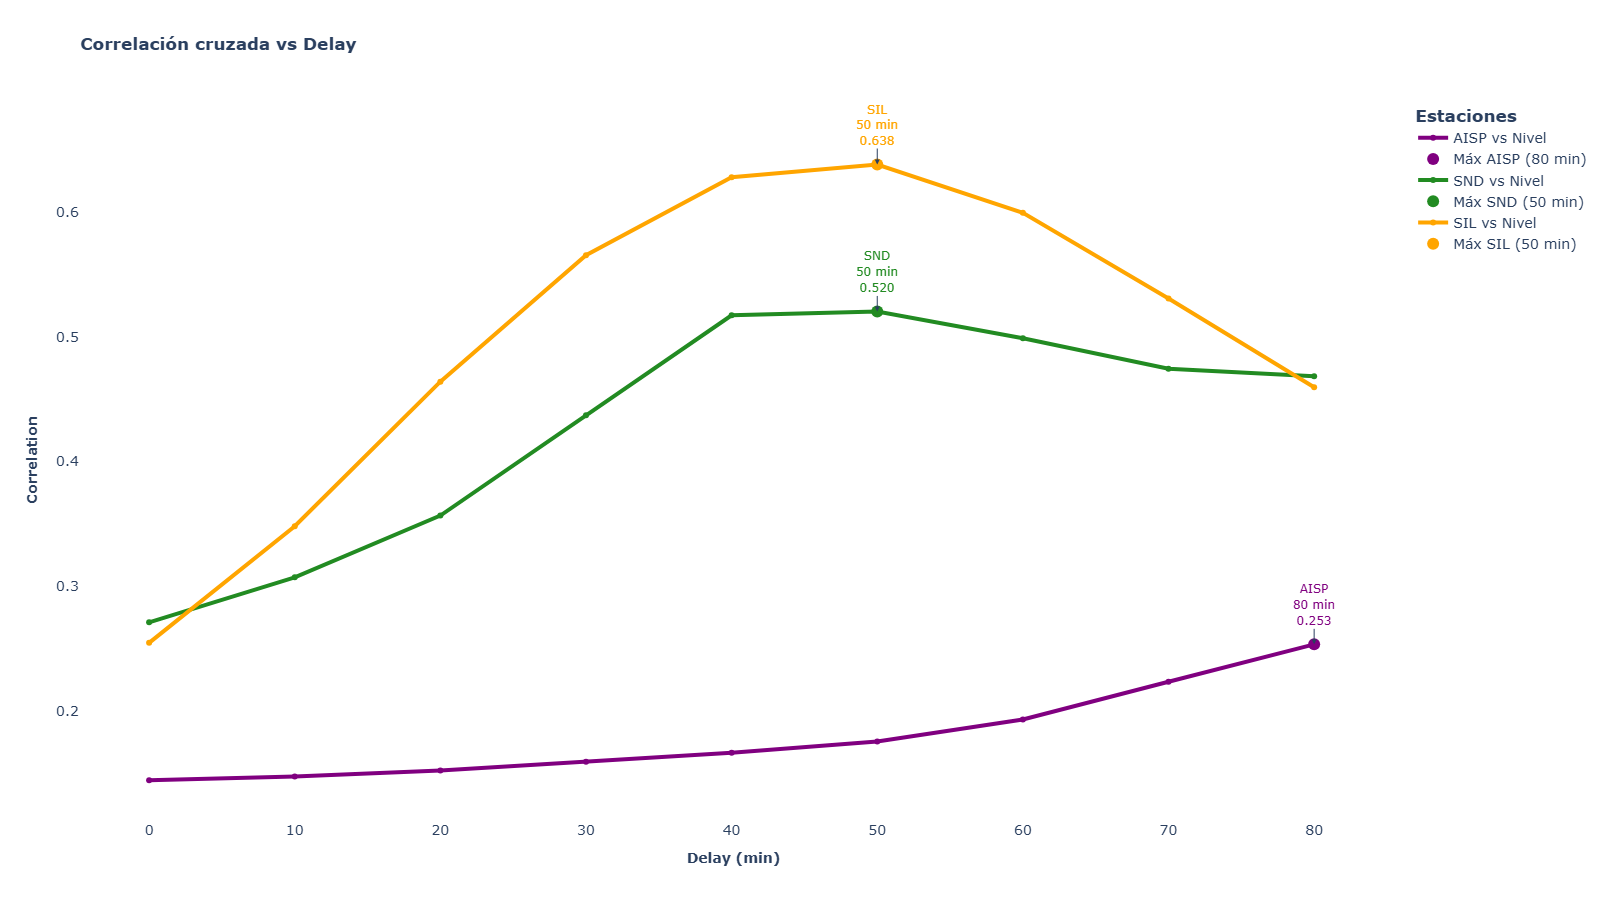

In [24]:
def cross_correlation(x, y, lag_step=10, min_delay=0, max_delay=80):
    corr = correlate(x, y, mode='full')
    lags = np.arange(-len(x) + 1, len(x))
    norm_factor = np.array([len(x) - abs(lag) for lag in lags])
    corr_norm = corr / norm_factor
    lags_minutes = lags * lag_step

    mask = (lags_minutes >= min_delay) & (lags_minutes <= max_delay)
    lags_minutes_filtered = lags_minutes[mask]
    corr_norm_filtered = corr_norm[mask]

    best_idx = np.argmax(np.abs(corr_norm_filtered))
    best_lag = lags_minutes_filtered[best_idx]
    best_corr = corr_norm_filtered[best_idx]

    return lags_minutes_filtered, corr_norm_filtered, best_lag, best_corr

# Extraer las señales
nivel1 = merged1_std['nivel_std'].values
aisp = merged1_std['aisp_std'].values
nivel2 = merged2_std['nivel_std'].values
snd = merged2_std['snd_std'].values
nivel3 = merged3_std['nivel_std'].values
sil = merged3_std['sil_std'].values

# Calcular las correlaciones
lags_aisp, corr_aisp, lag_aisp, corr_max_aisp = cross_correlation(nivel1, aisp)
lags_snd, corr_snd, lag_snd, corr_max_snd = cross_correlation(nivel2, snd)
lags_sil, corr_sil, lag_sil, corr_max_sil = cross_correlation(nivel3, sil)

# Crear la figura
fig = go.Figure()

fig.add_trace(go.Scatter(x=lags_aisp, y=corr_aisp, mode='lines+markers', name='AISP vs Nivel', line=dict(width=4, color='purple')))
fig.add_trace(go.Scatter(x=[lag_aisp], y=[corr_max_aisp], mode='markers', marker=dict(size=12, color='purple'), name=f'Máx AISP ({lag_aisp} min)'))

fig.add_trace(go.Scatter(x=lags_snd, y=corr_snd, mode='lines+markers', name='SND vs Nivel', line=dict(width=4, color='forestgreen')))
fig.add_trace(go.Scatter(x=[lag_snd], y=[corr_max_snd], mode='markers', marker=dict(size=12, color='forestgreen'), name=f'Máx SND ({lag_snd} min)'))

fig.add_trace(go.Scatter(x=lags_sil, y=corr_sil, mode='lines+markers', name='SIL vs Nivel', line=dict(width=4, color='orange')))
fig.add_trace(go.Scatter(x=[lag_sil], y=[corr_max_sil], mode='markers', marker=dict(size=12, color='orange'), name=f'Máx SIL ({lag_sil} min)'))

# Anotaciones
for lag, corr, label, color in [
    (lag_aisp, corr_max_aisp, "AISP", "purple"),
    (lag_snd, corr_max_snd, "SND", "forestgreen"),
    (lag_sil, corr_max_sil, "SIL", "orange")
]:
    fig.add_annotation(
        x=lag,
        y=corr,
        text=f"{label}<br>{lag} min<br>{corr:.3f}",
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40,
        bgcolor="white",
        font=dict(color=color)
    )

# Layout
fig.update_layout(
    title="<b>Correlación cruzada vs Delay<b>",
    xaxis_title="<b>Delay (min)<b>",
    yaxis_title="<b>Correlation<b>",
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=900,
    height=900,
    legend=dict(title='<b>Estaciones<b>',font=dict(size=14)),
    xaxis=dict(title_font=dict(size=14), tickfont=dict(size=14)),
    yaxis=dict(title_font=dict(size=14), tickfont=dict(size=14))
)

fig.show()